# Homework 1 - Using OLS
## Data Analysis
### FINM August Review 

Mark Hendricks

hendricks@uchicago.edu

$$\newcommand{\spy}{\text{spy}}$$
$$\newcommand{\hyg}{\text{hyg}}$$

# Data
* This homework uses the file, `data/multi_asset_etf_data.xlsx`.
* Find the data in the Github repo associated with the module, (link on Canvas.)

The data file contains...
* Return rates, $r_t^i$, for various asset classes, (via ETFs.)
* Most notable among these securities is SPY, the return on the S&P 500. Denote this as $r^{\spy}_t$.
* A separate tab gives return rates for a particular portfolio, $r_t^p$.

***

# 1. Regression
## 1. 
Estimate the regression of the portfolio return on SPY:

$$r^p_t = \alpha + \beta r^{\spy}_t + \epsilon_t^{p,\spy}$$

Specifically, report your estimates of alpha, beta, and the r-squared.




## 4. 
How do the SPY betas differ across the univariate and multivariate models? How does this relate to the
correlation between $r^{\spy}$ and $r^{\hyg}$?

## 5. 
Without doing any calculation, would you expect the sample residual of the univariate regression or multivariate regression to have higher correlation to $r^{\hyg}$?

In [1]:
import pandas as pd
import numpy as np
import random

import warnings

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV

import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

import seaborn as sns

In [33]:
INFILE = "../data/multi_asset_etf_data.xlsx"

rets_total = pd.read_excel(INFILE, sheet_name="total returns").set_index("Date")
rets_por = pd.read_excel(INFILE, sheet_name="portfolio returns").set_index("Date")

In [34]:
rets_total

,SPY,EFA,EEM,PSP,QAI,HYG,DBC,IYR,IEF,BWX,TIP,SHV
Date,,,,,,,,,,,,
2009-04-30,0.099346,0.115190,0.155582,0.230203,0.022883,0.138460,-0.001000,0.296151,-0.027453,0.008993,-0.017951,0.000553
2009-05-31,0.058454,0.131918,0.159400,0.053892,0.027865,0.028555,0.162663,0.022728,-0.020773,0.053672,0.019966,-0.000472
2009-06-30,-0.000655,-0.014049,-0.022495,0.045449,-0.003436,0.033517,-0.026259,-0.024863,-0.005571,0.005148,0.001981,0.000599
2009-07-31,0.074606,0.100415,0.110146,0.143247,0.015326,0.069190,0.018568,0.105799,0.008317,0.031284,0.000879,-0.000027
2009-08-31,0.036940,0.045030,-0.013136,0.033413,-0.004151,-0.016969,-0.040365,0.131939,0.007635,0.007628,0.008413,0.000436
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-31,0.015926,-0.004512,-0.045262,-0.006270,-0.003987,0.001163,0.013158,-0.050979,0.000726,-0.030630,0.003349,0.003995
2024-02-29,0.052187,0.029863,0.041678,0.041903,0.015677,0.003035,-0.015226,0.021326,-0.020826,-0.010788,-0.010477,0.003933
2024-03-31,0.032702,0.033786,0.027257,0.032782,0.014450,0.010898,0.044566,0.018538,0.007332,0.003882,0.006466,0.004161


In [3]:
TARGET = 'SPY'
X = rets_total[TARGET].to_frame() # X必须是dataframe
y = rets_por['portfolio'] # y必须是series

In [4]:
def estimate_reg(X,y,model=LinearRegression,penalty=None,DoIntercept=True):
    if model is LinearRegression:
        est = LinearRegression(fit_intercept=DoIntercept).fit(X,y)
    else:
        est = model(alpha=penalty, fit_intercept=DoIntercept).fit(X,y)
    
    betas = pd.Series(index = X.columns, dtype=float)

    betas.loc[X.columns] = est.coef_
    
    if DoIntercept:
        betas = pd.concat([pd.Series(index=['intercept'], data=est.intercept_), betas]) 

    r2 = est.score(X,y)
    
    return betas, r2

In [5]:
random.seed(10)
SPARSITY = 1/50

betas = pd.DataFrame(dtype=float, columns = ['OLS','OLS Random','Ridge','LASSO'])
rsquared = pd.DataFrame(dtype=float,index = betas.columns, columns=['full sample'])

In [6]:
MODEL = LinearRegression
betas['OLS'], r2 = estimate_reg(X,y,model=MODEL)
rsquared.loc['OLS','full sample'] = r2

In [7]:
betas['OLS']

intercept   -0.001628
SPY          0.652503
Name: OLS, dtype: float64

## 2. 
Estimate the regression of the portfolio return on SPY and on HYG, the return on high-yield
corporate bonds, denoted as $r^{\hyg}_t$:

$$r^p_t = {\alpha} + {\beta}^{\spy}r^{\spy}_t + {\beta}^{\hyg}r^{\hyg}_t + {\epsilon}_t$$

Specifically, report your estimates of alpha, the betas, and the r-squared.

*Note that the parameters (such as $\beta^{\spy}$) in this multivariate model are not the same as used in the univariate model of part 1. 

In [8]:

X = rets_total[['SPY','HYG']] # X必须是dataframe
y = rets_por['portfolio'] # y必须是series

In [9]:
random.seed(10)
SPARSITY = 1/50

betas = pd.DataFrame(dtype=float, columns = ['OLS','OLS Random','Ridge','LASSO'])
rsquared = pd.DataFrame(dtype=float,index = betas.columns, columns=['full sample'])

In [10]:
MODEL = LinearRegression
betas['OLS'], r2 = estimate_reg(X,y,model=MODEL)
rsquared.loc['OLS','full sample'] = r2

In [11]:
print(betas['OLS'])
print(rsquared)

intercept   -0.001671
SPY          0.404790
HYG          0.536997
Name: OLS, dtype: float64
            full sample
OLS            0.835363
OLS Random          NaN
Ridge               NaN
LASSO               NaN



## 3. 
Calculate the series of fitted regression values, sometimes referred to as $\hat{y}$ in standard textbooks:

$$\hat{r}^p_t = \hat{\alpha} + \hat{\beta}^{\spy}r^{\spy}_t + \hat{\beta}^{\hyg}r^{\hyg}_t$$

Your statistical package will output these fitted values for you, or you can construct them using the estimated parameters.

How does this compare to the r-squared of the regression in problem 2?

In [12]:
alpha_hat = betas['OLS']['intercept']
beta_spy_hat = betas['OLS']['SPY']
beta_hyg_hat = betas['OLS']['HYG']
r_p_hat = alpha_hat + beta_spy_hat * np.array(X['SPY']) + beta_hyg_hat * np.array(X['HYG'])

# 输出结果
print("r_p_hat:", r_p_hat)

r_p_hat: [ 0.11289575  0.0373241   0.0160621   0.06568318  0.00416929  0.04382168
 -0.01236898  0.03231214  0.02584719 -0.02622452  0.0210157   0.03442909
  0.01492541 -0.0589416  -0.01664871  0.05364891 -0.02519254  0.0542223
  0.02365841 -0.00851655  0.04038717  0.01662186  0.02009905 -0.00139521
  0.01863086 -0.00549506 -0.01156448 -0.00786299 -0.03857544 -0.05824073
  0.08811055 -0.01634842  0.02700244  0.02496632  0.02718859  0.00622957
  0.00173015 -0.04327697  0.03976265  0.00860678  0.01515296  0.01138599
 -0.00450501  0.00328754  0.00947052  0.02089045  0.00850185  0.01838416
  0.01747907 -0.00597545 -0.01614126  0.03457294 -0.02064287  0.01533461
  0.03059581  0.01286693  0.01100746 -0.01380051  0.02914951  0.00124885
  0.00340064  0.01420032  0.00997179 -0.0201697   0.02708504 -0.01790309
  0.01355683  0.0036432  -0.00701049 -0.00988946  0.03306099 -0.01311862
  0.00698885  0.00544144 -0.02002741  0.00483019 -0.0345234  -0.02805524
  0.05010904 -0.01359535 -0.01936576 -0.030

In [13]:
type(r_p_hat)

numpy.ndarray

In [14]:
ESS = np.sum((np.array(y)-r_p_hat) ** 2)
TSS = np.sum((np.array(y) - np.mean(y)) ** 2)
R_squared_test = 1 - ESS/TSS
print("R_squared_test:", R_squared_test)

R_squared_test: 0.8353634880706727


answer: the r-squared is the same

***

# 2. Decomposing and Replicating

## 1.
The portfolio return, $r_t^p$, is a combination of the base assets that are provided here. Use linear regression to uncover which weights were used in constructing the portfolio.

$$r_t^p = \alpha +\left(\boldsymbol{\beta}\right)' \boldsymbol{r}_t + \epsilon_t$$

where $\boldsymbol{r}$ denotes the vector of returns for the individual securities.
* What does the regression find were the original weights?
* How precise is the estimation? Consider the R-squared and t-stats.

*Feel free to include an $\alpha$ in this model, even though you know the portfolio is an exact function of the individual securities. The estimation should find $\alpha$ of (nearly) zero.*


## 2.

$$\newcommand{\targ}{EEM}$$

Suppose that we want to mimic a return, **EEM** using the other returns. Run the following regression–but
do so **only using data through the end of 2020.**

$$r_t^{\targ} = \alpha +\left(\boldsymbol{\beta}^{\boldsymbol{r}}\right)' \boldsymbol{r}_t + \epsilon_t$$

where $\boldsymbol{r}$ denotes the vector of returns for the other securities, excluding the target, **EEM**.

#### (a) 
Report the r-squared and the estimate of the vector, $\boldsymbol{\beta}$.

#### (b) 
Report the t-stats of the explanatory returns. Which have absolute value greater than 2?

#### (c) 
Plot the returns of **EEM** along with the replication values.



In [63]:
def estimate_reg_2(X, y, model=LinearRegression, penalty=None, DoIntercept=True):
    if model is LinearRegression:
        est = LinearRegression(fit_intercept=DoIntercept).fit(X, y)
    else:
        est = model(alpha=penalty, fit_intercept=DoIntercept).fit(X, y)

    betas = pd.Series(index=X.columns, dtype=float)
    betas.loc[X.columns] = est.coef_

    if DoIntercept:
        betas = pd.concat([pd.Series(index=['intercept'], data=est.intercept_), betas])

    r2 = est.score(X, y)
    
    # 计算标准误差
    if DoIntercept:
        X_design = np.column_stack([np.ones(X.shape[0]), X])
        df = X_design.shape[0] - X_design.shape[1]
    else:
        X_design = X
        df = X_design.shape[0] - X_design.shape[1]
    mse = np.sum((y - est.predict(X))**2) / df
    se_betas = pd.Series(np.sqrt(np.diag(mse * np.linalg.inv(X_design.T @ X_design))), index=betas.index)

    return betas, r2, se_betas

Solution 2 (a)

In [64]:
## 2
X = rets_total.drop(['EEM'], axis = 1) # X必须是dataframe
y = rets_total['EEM'] # y必须是series
X_filter = X[X.index < '2021-01-01']
y_filter = y[y.index < '2021-01-01']
random.seed(10)
SPARSITY = 1/50

betas = pd.DataFrame(dtype=float, columns = ['OLS','OLS Random','Ridge','LASSO'])
rsquared = pd.DataFrame(dtype=float,index = betas.columns, columns=['full sample'])
MODEL = LinearRegression
betas, r2, se_betas = estimate_reg_2(X_filter,y_filter,model=MODEL)


In [65]:
betas.to_frame()

,0
intercept,-0.001269
SPY,-0.112087
EFA,0.499741
PSP,-0.003538
QAI,0.760849
HYG,0.301275
DBC,-0.007864
IYR,0.068293
IEF,-0.981504
BWX,0.545010


In [66]:
r2

0.8203279417524802

solution 2(b)

In [67]:
t_stats = betas / se_betas

In [68]:
t_stats

intercept   -0.435972
SPY         -0.731679
EFA          3.648441
PSP         -0.031118
QAI          1.998270
HYG          1.673518
DBC         -0.116692
IYR          0.879751
IEF         -3.508249
BWX          3.302359
TIP          2.360670
SHV          1.208331
dtype: float64

solution 2(c)

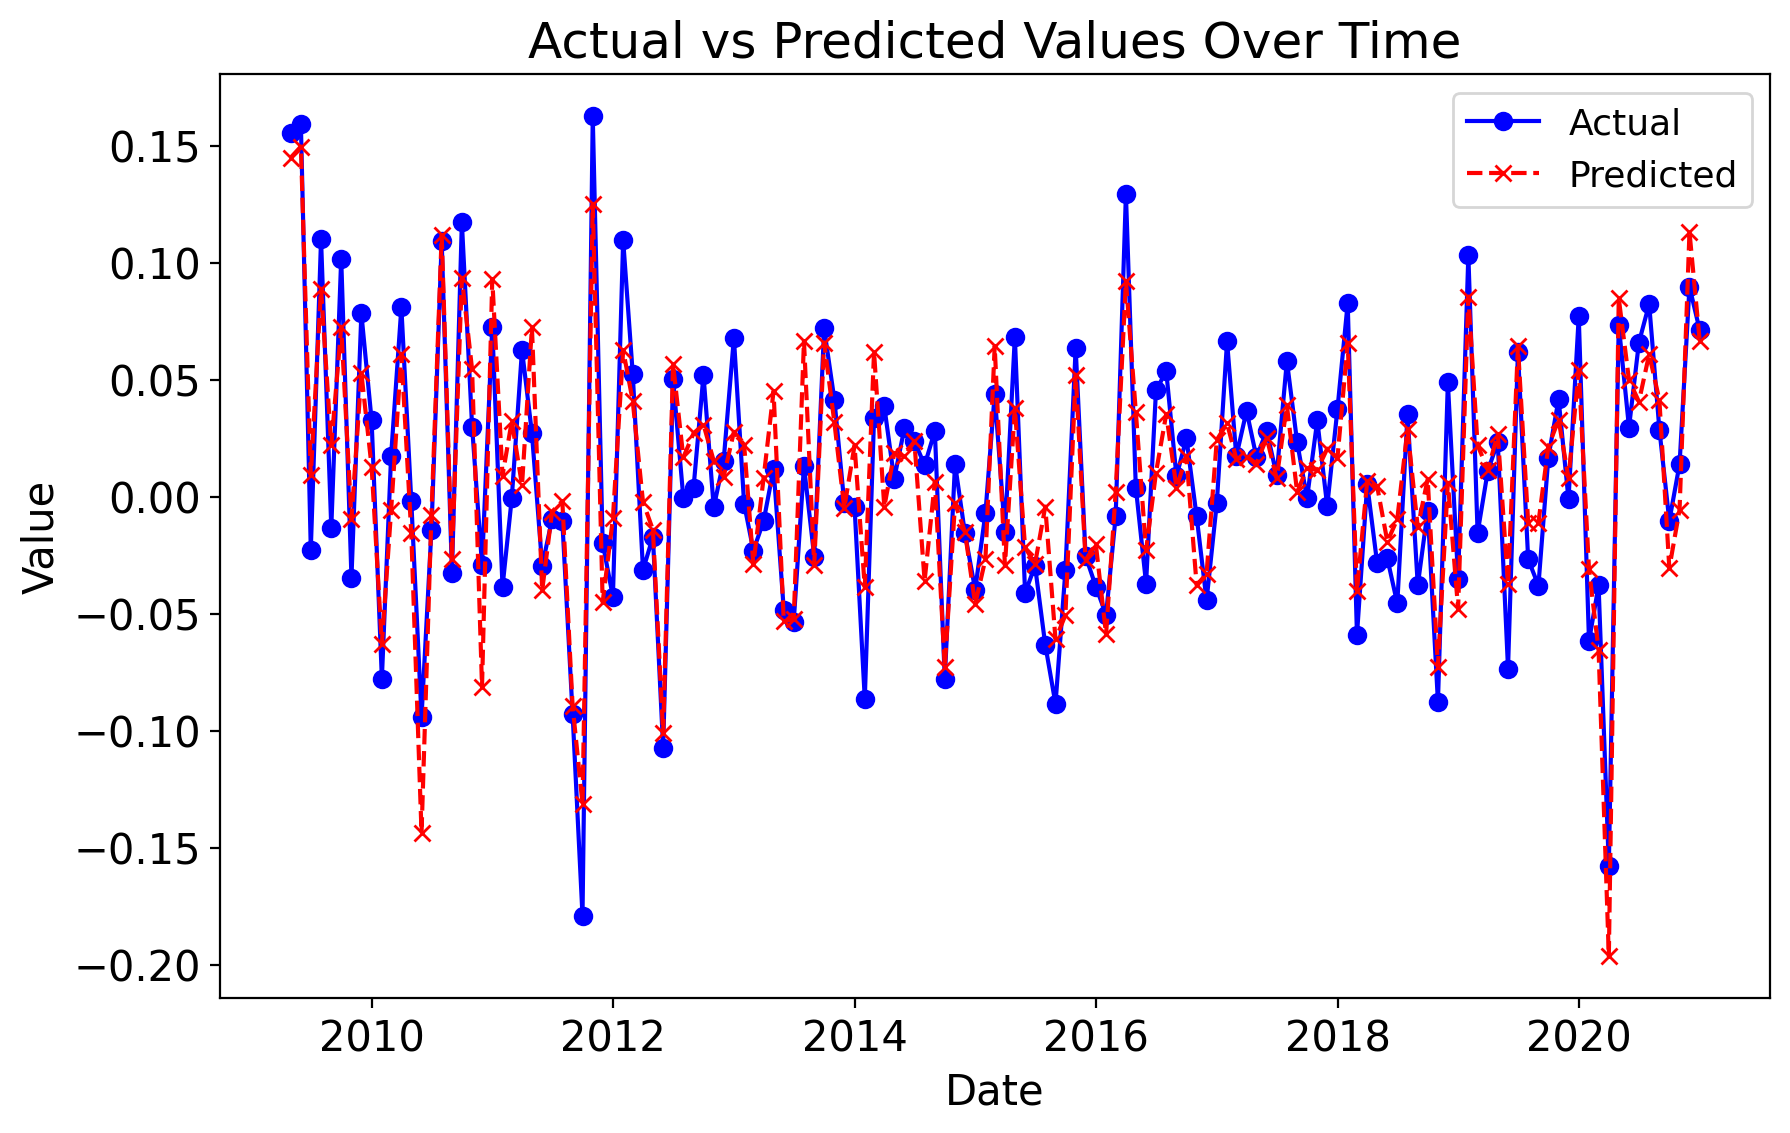

In [70]:
intercept = betas['intercept']
coefs = betas.drop('intercept')
y_pred = intercept + X_filter @ coefs

# 绘制实际值和预测值
plt.figure(figsize=(10, 6))
plt.plot(y_filter.index, y_filter, color='blue', label='Actual', marker='o')
plt.plot(y_pred.index, y_pred, color='red', label='Predicted', linestyle='--', marker='x')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values Over Time')
plt.legend()
plt.show()

## 3.
Perhaps the replication results in the previous problem are overstated given that they estimated the parameters within a sample and then evaluated how well the result fit in the same sample. This is known as in-sample fit.

Using the estimates through **2020**, (the α and βˆ from the previous problem,) calculate the out-of-sample (OOS) values of the replication, using the **2021-2023** returns, denoted $\boldsymbol{r}_t^{\text{oos}}$:

$$\hat{r}_t^{\targ} = \left(\widehat{\boldsymbol{\beta}}^{\boldsymbol{r}}\right)' \boldsymbol{r}_t^{\text{oos}}$$

#### (a) 
What is the correlation between $\hat{r}_t^{\targ}$ and $\boldsymbol{r}_t^{\text{oos}}$?

#### (b) 
How does this compare to the r-squared from the regression above based on in-sample data, (through 2020?)

***